# Consumption prediction
### Author : Nicolas Lacroix (https://github.com/NicolasLacroix)

Licence : [Apache License 2.0]

This notebook uses [consumption.ipynb] and [meteorology.ipynb].

[Apache License 2.0]: https://github.com/NicolasLacroix/data-representation/blob/master/LICENSE

[consumption.ipynb]: https://github.com/NicolasLacroix/data-representation/blob/master/notebooks/consumption.ipynb
[meteorology.ipynb]: https://github.com/NicolasLacroix/data-representation/blob/master/notebooks/meteorology.ipynb

In [37]:
import torch
import torch.nn as nn

## I. Data

### Importing data

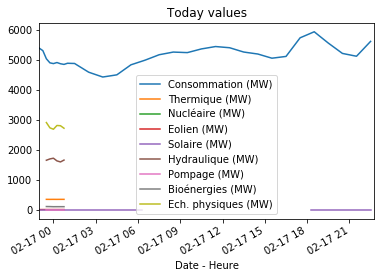

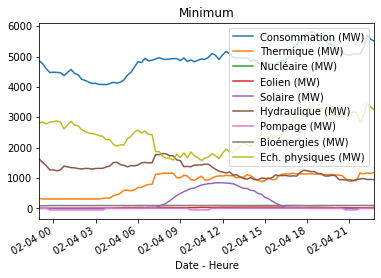

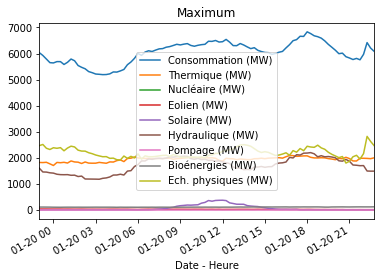

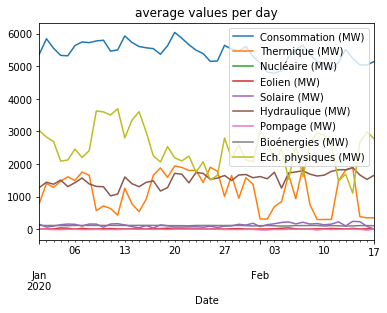

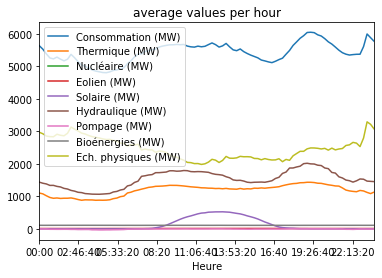

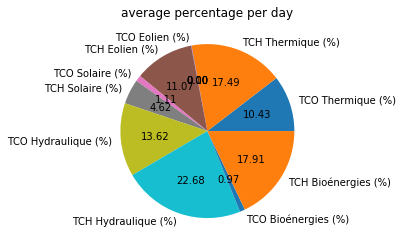

(115233, 81)
(29003, 18)


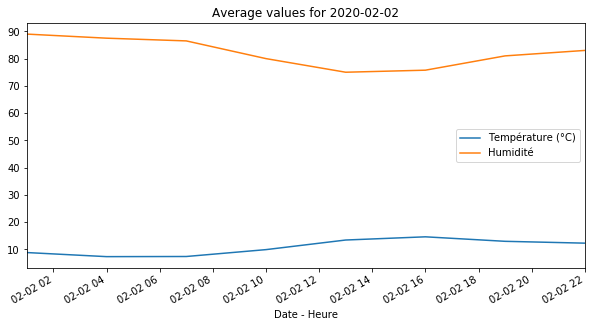

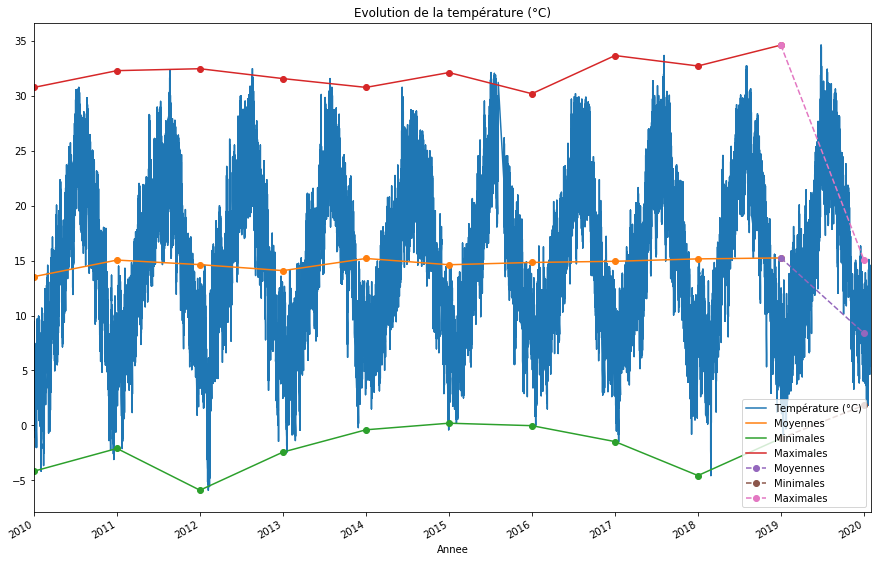

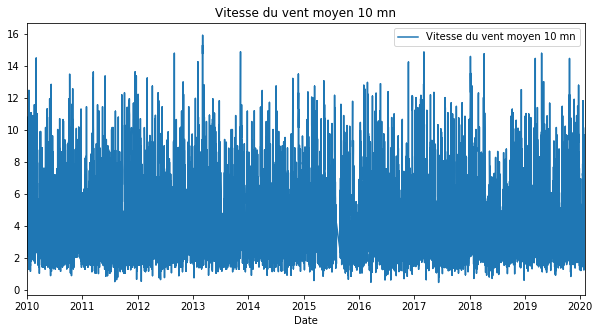

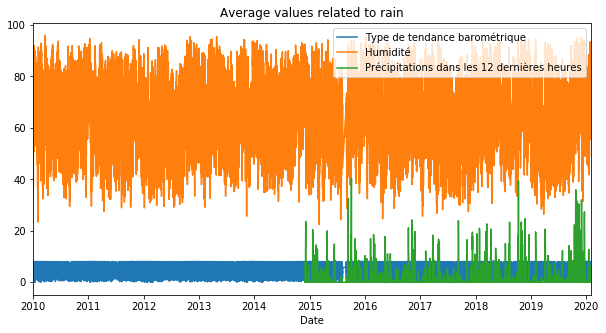

In [38]:
%run consumption.ipynb # import data
%run meteorology.ipynb # import data_meteo

### Processing data

In [39]:
def extractDate(data):
    data['Minute'] = data["Heure"].apply(lambda x : x.minute)
    data["Heure"] = data["Heure"].apply(lambda x : x.hour)
    data["Heure"] = data["Heure"].values.astype(np.float64)
    data["Minute"] = data["Minute"].values.astype(np.float64)
    return data

In [40]:
print(data_meteo['Date'].dtypes == data['Date'].dtypes)
# converting data_meteo['Date']'s' type to match data['Date']'s type
data_meteo['Date'] = pd.to_datetime(data_meteo['Date'])
print(data['Date'].dtypes == data_meteo['Date'].dtypes)

False
True


In [41]:
data_meteo['Date - Heure'] = pd.to_datetime(data_meteo['Date - Heure'], format='%Y-%m-%dT%H:%M:%S', utc=True)
print(data.dtypes)
data_meteo.dtypes

Code INSEE région                    int64
Région                              object
Nature                              object
Date                        datetime64[ns]
Heure                               object
Date - Heure           datetime64[ns, UTC]
Consommation (MW)                  float64
Thermique (MW)                     float64
Nucléaire (MW)                     float64
Eolien (MW)                        float64
Solaire (MW)                       float64
Hydraulique (MW)                   float64
Pompage (MW)                       float64
Bioénergies (MW)                   float64
Ech. physiques (MW)                float64
TCO Thermique (%)                  float64
TCH Thermique (%)                  float64
TCO Nucléaire (%)                  float64
TCH Nucléaire (%)                  float64
TCO Eolien (%)                     float64
TCH Eolien (%)                     float64
TCO Solaire (%)                    float64
TCH Solaire (%)                    float64
TCO Hydraul

Date                                                datetime64[ns]
Annee                                                        int64
Heure                                                       object
Date - Heure                                   datetime64[ns, UTC]
Pression au niveau mer                                     float64
Variation de pression en 3 heures                          float64
Type de tendance barométrique                              float64
Direction du vent moyen 10 mn                              float64
Vitesse du vent moyen 10 mn                                float64
Point de rosée                                             float64
Humidité                                                   float64
Temps présent                                              float64
Pression station                                           float64
Rafales sur une période                                    float64
Periode de mesure de la rafale                             flo

## II. Prediction

In [42]:
TRAIN_SPLIT = 400 # size of the training dataset
NB_DAYS = 10 # number of days to be predicted

### Training dataset

In [43]:
# TODO: normalize all columns or only Consuming ?
# TODO: improve performances
data_train = pd.concat([data, data_meteo], axis=1, join='inner')[:TRAIN_SPLIT-NB_DAYS]
# normalizing data
data_train_mean = data_train["Consommation (MW)"].mean()
data_train_std = data_train["Consommation (MW)"].std()
data_train["Consommation (MW)"] = (data_train["Consommation (MW)"]-data_train_mean)/data_train_std
# final training dataset
data_train

,Code INSEE région,Région,Nature,Date,Heure,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),...,Temps présent,Pression station,Rafales sur une période,Periode de mesure de la rafale,Précipitations dans la dernière heure,Précipitations dans les 3 dernières heures,Précipitations dans les 6 dernières heures,Précipitations dans les 12 dernières heures,Type de tendance barométrique.1,Température (°C)
0,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-01,01:45:00,2020-01-01 00:45:00+00:00,-0.069771,1093.0,NaN,1.0,...,6.000000,96062.5,6.550,-10.0,0.20,0.20,0.25,NaN,7.750000,9.475
1,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-01,02:00:00,2020-01-01 01:00:00+00:00,0.036434,1055.0,NaN,1.0,...,31.666667,95780.0,8.325,-10.0,0.20,0.25,NaN,NaN,7.000000,8.950
2,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-01,02:15:00,2020-01-01 01:15:00+00:00,0.406919,1084.0,NaN,1.0,...,21.000000,95772.5,11.300,-10.0,0.00,0.80,NaN,1.333333,6.333333,7.625
3,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-01,03:00:00,2020-01-01 02:00:00+00:00,-0.543992,341.0,NaN,1.0,...,45.000000,96005.0,9.900,-10.0,0.35,0.85,NaN,NaN,2.000000,7.600
4,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-01,03:30:00,2020-01-01 02:30:00+00:00,-0.781102,236.0,NaN,1.0,...,35.250000,96112.5,12.475,-10.0,0.10,0.40,1.25,NaN,1.000000,8.525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,09:30:00,2020-01-20 08:30:00+00:00,1.651747,1942.0,NaN,22.0,...,44.000000,96730.0,6.675,-10.0,0.15,0.25,NaN,NaN,1.750000,7.075
386,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,09:45:00,2020-01-20 08:45:00+00:00,1.765362,1967.0,NaN,23.0,...,11.500000,96917.5,6.300,-10.0,0.00,0.15,NaN,2.000000,3.000000,6.825
387,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,10:00:00,2020-01-20 09:00:00+00:00,1.703615,1974.0,NaN,22.0,...,21.000000,97185.0,6.300,-10.0,0.05,0.05,NaN,NaN,2.500000,8.275
388,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,10:30:00,2020-01-20 09:30:00+00:00,1.829579,2003.0,NaN,21.0,...,1.500000,97192.5,4.500,-10.0,0.00,0.20,0.25,NaN,3.250000,11.600


In [57]:
data_train[['Date', 'Heure', 'Consommation (MW)']]

,Date,Date,Heure,Heure,Consommation (MW)
0,2020-01-01,2010-01-01,01:45:00,00:00:00,-0.069771
1,2020-01-01,2010-01-01,02:00:00,03:00:00,0.036434
2,2020-01-01,2010-01-01,02:15:00,06:00:00,0.406919
3,2020-01-01,2010-01-01,03:00:00,09:00:00,-0.543992
4,2020-01-01,2010-01-01,03:30:00,12:00:00,-0.781102
...,...,...,...,...,...
385,2020-01-20,2010-02-18,09:30:00,03:00:00,1.651747
386,2020-01-20,2010-02-18,09:45:00,06:00:00,1.765362
387,2020-01-20,2010-02-18,10:00:00,09:00:00,1.703615
388,2020-01-20,2010-02-18,10:30:00,12:00:00,1.829579


### Target dataset

In [54]:
target_data = pd.concat([data, data_meteo], axis=1, join='inner')[TRAIN_SPLIT-NB_DAYS:TRAIN_SPLIT]
# TODO : .values.astype(np.float64)
target_data

,Code INSEE région,Région,Nature,Date,Heure,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),...,Temps présent,Pression station,Rafales sur une période,Periode de mesure de la rafale,Précipitations dans la dernière heure,Précipitations dans les 3 dernières heures,Précipitations dans les 6 dernières heures,Précipitations dans les 12 dernières heures,Type de tendance barométrique.1,Température (°C)
390,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,12:30:00,2020-01-20 11:30:00+00:00,6501.0,1979.0,NaN,18.0,...,1.500000,97177.5,5.800,-10.0,0.00,0.00,NaN,0.25,2.75,10.075
391,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,15:45:00,2020-01-20 14:45:00+00:00,6076.0,1982.0,NaN,19.0,...,1.500000,97052.5,8.750,-10.0,0.00,0.00,NaN,NaN,7.00,9.025
392,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,16:45:00,2020-01-20 15:45:00+00:00,6004.0,1996.0,NaN,17.0,...,20.750000,96805.0,10.650,-10.0,0.15,0.15,0.15,NaN,8.00,9.650
393,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,17:15:00,2020-01-20 16:15:00+00:00,6081.0,1985.0,NaN,17.0,...,61.250000,96110.0,18.400,-10.0,1.10,2.00,NaN,NaN,6.50,9.400
394,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,17:45:00,2020-01-20 16:45:00+00:00,6341.0,2088.0,NaN,16.0,...,61.750000,95757.5,15.850,-10.0,2.15,6.00,NaN,8.25,7.00,8.400
395,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,18:00:00,2020-01-20 17:00:00+00:00,6493.0,2082.0,NaN,18.0,...,61.666667,95615.0,14.125,-10.0,1.90,6.50,NaN,NaN,5.50,7.900
396,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,20:15:00,2020-01-20 19:15:00+00:00,6485.0,1996.0,NaN,13.0,...,35.500000,95687.5,14.400,-10.0,0.30,2.75,9.25,NaN,4.25,9.325
397,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,21:15:00,2020-01-20 20:15:00+00:00,5994.0,1974.0,NaN,10.0,...,29.000000,95892.5,13.625,-10.0,0.10,0.45,NaN,NaN,3.00,9.700
398,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,22:00:00,2020-01-20 21:00:00+00:00,5829.0,1969.0,NaN,8.0,...,0.750000,96095.0,10.650,-10.0,0.00,0.00,NaN,9.50,2.00,7.700
399,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,22:30:00,2020-01-20 21:30:00+00:00,5813.0,1875.0,NaN,8.0,...,1.500000,96270.0,12.200,-10.0,0.00,0.00,NaN,NaN,2.25,6.075


### Neural Network

In [45]:
# number of criterias 
nbIn = data_train.shape[1]
# neural network caracteristics
nbOut = 1
nbHidden = 100
# définition of the neural network
neuralNetwork = nn.Sequential(nn.Linear(nbIn,nbHidden), nn.ReLU(), nn.Linear(nbHidden,nbOut))
neuralNetwork

Sequential(
  (0): Linear(in_features=49, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

In [46]:
# launch criterias + optimizing options
criterion = nn.MSELoss() # MSELoss = moindres carrés
optimizer = torch.optim.SGD(neuralNetwork.parameters(), lr=0.000003) # lr = learning rate
nbEpochs = 1000 # nombre d'itérations

In [47]:
# converting data (to pytorch tensor)
input_data = torch.FloatTensor(data_train.values)
target = torch.FloatTensor(target_data.values)
#target = torch.FloatTensor(target_data.values.reshape((TRAIN_SPLIT, )))
#target = target.unsqueeze(0)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, int64, int32, int16, int8, uint8, and bool.

### Training

In [ ]:
items = []
# launching iterations
for epoch in range(nbEpochs):
    optimizer.zero_grad() # zero_grad = ?
    output = neuralNetwork(input_data)
    print(output) # TODO: check output content (maybe prediction results)
    loss = criterion(output, target) # calcul de la fonction cout (moindres carrés)
    loss.backward() # calcul du gradient (sens = droite vers gauche)
    optimizer.step() # ? (modification des parametres du réseau de neurones)
    print(loss.item())
    items.append(loss.item())

### Results

In [ ]:
# neural network performances (loss stats)
fig, ax = plt.subplots()
x = np.arange(len(items))
ax.plot(x, items)
# TODO: improve ylabel+title
ax.set(xlabel='number of epochs', ylabel='consumption',
       title='Evolution')
plt.show()

In [ ]:
# results
# gca = get current axis
ax = plt.gca()
# dataset values
# TODO: remove label='Consommaation' ?
# TODO: specify title
data_train[['Date', 'Consommation (MW)']].plot(
    x='Date', label='Consommation', title="TODO", figsize=(15, 10), ax=ax, color="b"
)
data_target[['Date', 'Consommation (MW)']].plot(
    x='Date', label='Consommation', title="TODO", figsize=(15, 10), ax=ax, color="b"
)
# prediction results
# TODO: plot prediction results